## Estudio de cómo afectan los errores al experimento del polarímetro

**Autor**: Jesús del Hoyo

**Fecha**:   16/10/2018

**Objetivo**: Ecograb project, polariscope callibration

**Explicación**:

Sabemos que tenemos errores, bien de la calibración, de la estabilidad de la fuente, etc. Estos errores tienen que afectar por fuerza a la determinación de la matriz de Mueller de la muestra, y de ahí a la determinación de los parámetros de la descomposición. En este programa voy a analizar su influencia de manera teórica.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_2d, generate_even_distribution
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting
from matplotlib.colors import LogNorm
from matplotlib import ticker, colors


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import polarimeter.polarimeter as opsys
import numpy as np
import os

## Cargar datos

** Datos experimentales **

In [3]:
intensity_0 = np.array([-0.0243, 0.0217])
# Load file, Illumination maximum
filename = 'Intensidad_max_2018-10-01.npz'
data = np.load(filename)
# Rename variables
Iindividual = data['Iindividual']
Naverage = data['Naverage']
# Make stadistics
mean = np.mean(Iindividual, axis=0)
print(mean)

[5.9535574 4.2471744]


** Datos teóricos**

In [4]:
# Already characterized elements
(p11,p12, delay1) = (0.962421338047, 0.0723017114037, 109.674226344*degrees)
(p21, p22) = (0.974429083571, 0.0933985896782)
th0p1 = (122.449494104)*degrees #
th0p2 = (104.736748578)*degrees # + 135.633
th0p1ad = 4.49058478366*degrees
parR1 = [1.00633931598, 1.01339903131, 84.6008729373*degrees]
th0r1 = 175.571888512*degrees
th0r1ad = 9.1554487636*degrees
parR2 = [0.932112996884, 0.936748373013, 81.6800679199*degrees]
th0r2 = 2.78054116251*degrees
Jp1 = ps.Mueller_Real_Retarder(p11, p12, delay1)
Jp2 = ps.polarizer_linear(p21, p22)
Jr1 = ps.Mueller_Real_Retarder(parR1[0], parR1[1], parR1[2])
Jr2 = ps.Mueller_Real_Retarder(parR2[0], parR2[1], parR2[2])
M = [Jp1, Jr1, Jr2, Jp2]
th0 = [th0p1+th0p1ad, th0r1+th0r1ad, th0r2, th0p2]
Ifuente = np.matrix(np.array([[5.86922518], [0.56906085], [-0.25053408], [5.83619796]]))

** Funciones auxiliares **

In [85]:
def plot_4_figures(Zinfo, extension, aspect_ratio, LowThres, HighThres):
    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.subplot(2,2,1)
    IDimage = plt.imshow(
            Zinfo[0],
            interpolation='bilinear',
            aspect=aspect_ratio,
            origin='lower',
            norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Average error")
    plt.colorbar()
    IDimage.set_cmap("magma")

    plt.subplot(2,2,2)
    IDimage = plt.imshow(
            Zinfo[1],
            interpolation='bilinear',
            aspect=aspect_ratio,
            origin='lower',
            norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Deviation in error")
    plt.colorbar()
    IDimage.set_cmap("magma")

    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.subplot(2,2,3)
    IDimage = plt.imshow(
            Zinfo[2],
            interpolation='bilinear',
            aspect=aspect_ratio,
            origin='lower',
            norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Average error (filtered)")
    plt.colorbar()
    IDimage.set_cmap("magma")

    plt.subplot(2,2,4)
    IDimage = plt.imshow(
            Zinfo[3],
            interpolation='bilinear',
            aspect=aspect_ratio,
            origin='lower',
            norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Deviation in error (filtered)")
    plt.colorbar()
    IDimage.set_cmap("magma")
    
def plot_4_contours(Zinfo, extension, aspect_ratio, LowThres, HighThres, Nlevels=3):
    # Create levels
    lev_min = np.floor(np.log10(LowThres))
    lev_max = np.ceil(np.log10(HighThres))
    Nlevels = (lev_max-lev_min) * np.ceil(Nlevels) +1
    levs = np.logspace(lev_min, lev_max, Nlevels)
    
    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.subplot(2,2,1)
    IDimage = plt.contourf(
            Zinfo[0],
            interpolation='bilinear',
            aspect=aspect_ratio,
            levels = levs,
            norm=colors.LogNorm(),
            origin='lower',
            #norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Average error")
    plt.colorbar()
    IDimage.set_cmap("magma")

    plt.subplot(2,2,2)
    IDimage = plt.contourf(
            Zinfo[1],
            interpolation='bilinear',
            aspect=aspect_ratio,
            levels = levs,
            norm=colors.LogNorm(),
            origin='lower',
            #norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Deviation in error")
    plt.colorbar()
    IDimage.set_cmap("magma")

    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.subplot(2,2,3)
    IDimage = plt.contourf(
            Zinfo[2],
            interpolation='bilinear',
            aspect=aspect_ratio,
            levels = levs,
            norm=colors.LogNorm(),
            origin='lower',
            #norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Average error (filtered)")
    plt.colorbar()
    IDimage.set_cmap("magma")

    plt.subplot(2,2,4)
    IDimage = plt.contourf(
            Zinfo[3],
            interpolation='bilinear',
            aspect=aspect_ratio,
            levels = levs,
            norm=colors.LogNorm(),
            origin='lower',
            #norm=LogNorm(vmin=LowThres, vmax=HighThres),
            extent=extension)
    plt.xlabel("Error amplitude")
    plt.ylabel("Number of measurements")
    plt.title("Deviation in error (filtered)")
    plt.colorbar()
    IDimage.set_cmap("magma")
    
def plot_3_cortes(x, Zinfo,DZinfo, xlabel, titles, legends, LowThres, HighThres, logscale=False):
    # Plot 1D
    plt.figure()
    plt.figure(figsize=(21, 4))
    ax = plt.subplot(1,3,1)
    if logscale:
        ax.set_yscale("log", nonposy='clip')
    plt.errorbar(x, Zinfo[0], yerr = DZinfo[0], fmt='r')
    plt.errorbar(x, Zinfo[1], yerr = DZinfo[1], fmt='k')
    plt.title(titles[0] )    
    plt.legend(legends)
    plt.xlabel(xlabel)
    plt.ylabel("Error")
    ax.set_ylim(bottom = LowThres, top = HighThres)

    #plt.figure()
    ax = plt.subplot(1,3,2)
    if logscale:
        ax.set_yscale("log", nonposy='clip')
    plt.errorbar(x, Zinfo[2], yerr = DZinfo[2], fmt='r')
    plt.errorbar(x, Zinfo[3], yerr = DZinfo[3], fmt='k')
    plt.title(titles[1] )    
    plt.legend(legends)
    plt.xlabel(xlabel)
    plt.ylabel("Error")
    ax.set_ylim(bottom = LowThres, top = HighThres)
    
    ax = plt.subplot(1,3,3)
    if logscale:
        ax.set_yscale("log", nonposy='clip')
    plt.errorbar(x, Zinfo[4], yerr = DZinfo[4], fmt='r')
    plt.errorbar(x, Zinfo[5], yerr = DZinfo[5], fmt='k')
    plt.title(titles[2] )    
    plt.legend(legends)
    plt.xlabel(xlabel)
    plt.ylabel("Error")
    ax.set_ylim(bottom = LowThres, top = HighThres)

## Errores en intensidad: Determinación de la matriz de Mueller

Vamos a empezar por el caso mas basico, el aire (matriz identidad). De primeras, voy a suponer que el ruido en las medidas de intensidad es Gaussiano.

** Aire**

In [50]:
# Parameters
(n0, n1, nn) = (20, 200, 20) # Number of intensity measurements: min, max and Nvalues
#(a0, a1, an) = (0, 0.05, 11) # Amplitude of errors: min, max and Nvalues
(a0, a1, an) = (0, 0.02, 11) # Amplitude of errors: min, max and Nvalues
Naverage = 10 # Number of times the experiment is repeated in order to average errors
angle_limits = [0, pi, pi, 0] # Limits in the movement of motors
Nmax_angles = [0, 0, 0, 0] # Maximum number of different partitions in each motor (0 is no limit)
method_angles = 'linear'
threshold = 0.5
thresholdDev = 0.5
tolerance_filter = 0.01
aspect_ratio = 0.8e-4
LowThres = 1e-3
HighThres = 0.25
FilterThres = 1
indicesA = [1, 4, 7]

# Create target matrix
Mtarget = ps.polarizer_linear(0.95, 0.1)
Mpolarimeter = [Jp1, Jr1, Mtarget, Jr2, Jp2]

# Create  and initialize variables
narray = np.linspace(n0, n1, nn, dtype = 'int')
aarray = np.linspace(a0, a1, an)
mean_error = np.zeros((nn, an))
dev_error = np.zeros((nn, an))
mean_error_filtered = np.zeros((nn, an))
dev_error_filtered = np.zeros((nn, an))

# Loops introducing error
for indN, n_meas in enumerate(narray):
    for indA, a_error in enumerate(aarray): 
        # Initialize values
        error = np.zeros(Naverage)
        error_filtered = np.zeros(Naverage)
        for indAver in range(Naverage):
            # Angles
            angles = generate_even_distribution(n_meas, angle_limits, method_angles, Nmax_angles)
            # Simulated polarimeter experiment
            Iexp = np.zeros(n_meas)
            for indExp in range(n_meas):
                # Calculate the exact value
                th2 = [angles[0,indExp], angles[1,indExp], 0, angles[2,indExp], angles[3,indExp]]
                Iexp[indExp] = Intensity_Rotating_Elements(Mpolarimeter, th2, Ifuente)
                # Add noise
                noise = np.sign(np.random.rand(1)-0.5) * a_error * sqrt(np.log(np.random.rand(1)**(-1)))
                #print(noise)
                Iexp[indExp] = (1 + noise) * Iexp[indExp]
            # Calculate the matrix of the sample
            Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Iexp, angles)
            #print(Mcalculated)
            # Calculate error
            error[indAver] = np.std(Mtarget-Mcalculated)
            # Filter it if the error is not too high (in those cases we obtain errors)
            #print(error[indAver])
            if error[indAver] > FilterThres:
                Mfiltered = np.identity(4)*10
            else:
                Mfiltered = amm.filter_reality_conditions(Mcalculated, tolerance_filter, verbose=False)
            error_filtered[indAver] = np.std(Mtarget-Mfiltered)
        # Average error
        mean_error[indN, indA] = np.mean(error)
        dev_error[indN, indA] = np.std(error)
        mean_error_filtered[indN, indA] = np.mean(error_filtered)
        dev_error_filtered[indN, indA] = np.std(error_filtered)
        


<Figure size 432x288 with 0 Axes>

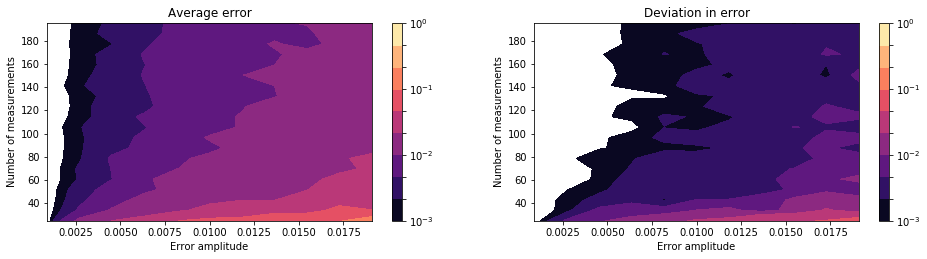

<Figure size 432x288 with 0 Axes>

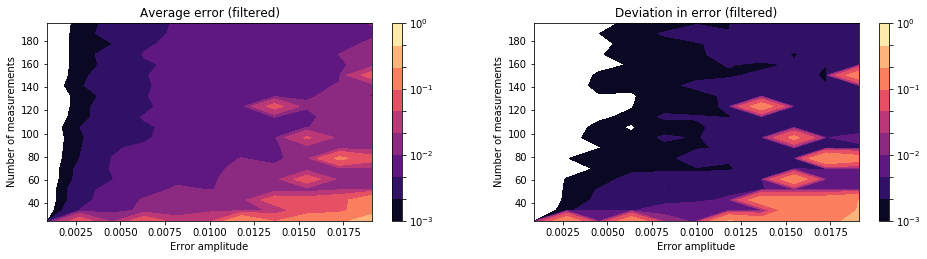

<Figure size 432x288 with 0 Axes>

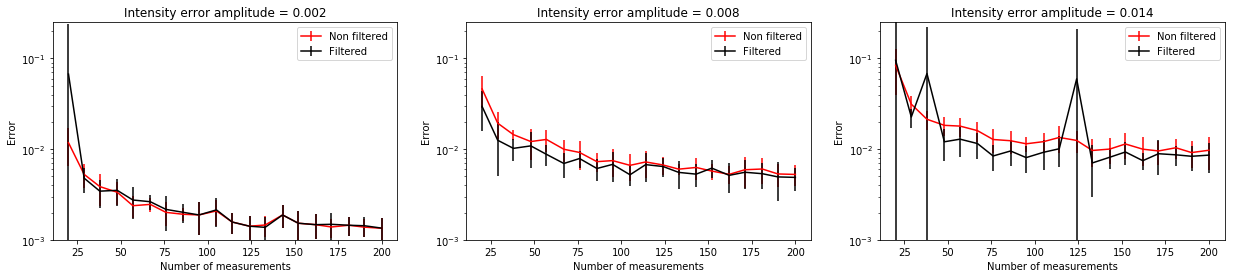

In [67]:
# Plot 2D
#print([narray.shape, aarray.shape, error.shape])
extension = sp.array([aarray[0], aarray[-1], narray[0], narray[-1]])
Zinfo = [mean_error, dev_error, mean_error_filtered, dev_error_filtered]
plot_4_contours(Zinfo, extension, aspect_ratio, LowThres, HighThres, Nlevels=5)

# Plot 1D
Zinfo = [mean_error[:,indicesA[0]], mean_error_filtered[:,indicesA[0]], 
        mean_error[:,indicesA[1]], mean_error_filtered[:,indicesA[1]], 
        mean_error[:,indicesA[2]], mean_error_filtered[:,indicesA[2]]]
DZinfo = [dev_error[:,indicesA[0]], dev_error_filtered[:,indicesA[0]], 
         dev_error[:,indicesA[1]], dev_error_filtered[:,indicesA[1]],
         dev_error[:,indicesA[2]], dev_error_filtered[:,indicesA[2]]]
titles = ['Intensity error amplitude = {}'.format(aarray[indicesA[0]]), 
         'Intensity error amplitude = {}'.format(aarray[indicesA[1]]), 
         'Intensity error amplitude = {}'.format(aarray[indicesA[2]]) ]
legends = ['Non filtered', 'Filtered']
xlabel = 'Number of measurements'
plot_3_cortes(narray, Zinfo,DZinfo, xlabel, titles, legends, LowThres, HighThres, logscale=True)

** Diatenuador**

In [72]:
# Parameters
(n0, n1, nn) = (20, 200, 20) # Number of intensity measurements: min, max and Nvalues
#(a0, a1, an) = (0, 0.05, 11) # Amplitude of errors: min, max and Nvalues
(a0, a1, an) = (0, 0.02, 11) # Amplitude of errors: min, max and Nvalues
Naverage = 10 # Number of times the experiment is repeated in order to average errors
angle_limits = [0, pi, pi, 0] # Limits in the movement of motors
Nmax_angles = [0, 0, 0, 0] # Maximum number of different partitions in each motor (0 is no limit)
method_angles = 'linear'
threshold = 0.5
thresholdDev = 0.5
tolerance_filter = 0.01
aspect_ratio = 0.8e-4
LowThres = 1e-4
HighThres = 1
FilterThres = 1
indicesA = [1, 4, 7]

# Create target matrix
Mtarget = ps.polarizer_linear(0.95, 0.1)
Mtarget = ps.rotate_mueller(Mtarget, 30*degrees)
Mpolarimeter = [Jp1, Jr1, Mtarget, Jr2, Jp2]

# Create  and initialize variables
narray = np.linspace(n0, n1, nn, dtype = 'int')
aarray = np.linspace(a0, a1, an)
mean_error = np.zeros((nn, an))
dev_error = np.zeros((nn, an))
mean_error_filtered = np.zeros((nn, an))
dev_error_filtered = np.zeros((nn, an))

# Loops introducing error
for indN, n_meas in enumerate(narray):
    for indA, a_error in enumerate(aarray): 
        # Initialize values
        error = np.zeros(Naverage)
        error_filtered = np.zeros(Naverage)
        for indAver in range(Naverage):
            # Angles
            angles = generate_even_distribution(n_meas, angle_limits, method_angles, Nmax_angles)
            # Simulated polarimeter experiment
            Iexp = np.zeros(n_meas)
            for indExp in range(n_meas):
                # Calculate the exact value
                th2 = [angles[0,indExp], angles[1,indExp], 0, angles[2,indExp], angles[3,indExp]]
                Iexp[indExp] = Intensity_Rotating_Elements(Mpolarimeter, th2, Ifuente)
                # Add noise
                noise = np.sign(np.random.rand(1)-0.5) * a_error * sqrt(np.log(np.random.rand(1)**(-1)))
                #print(noise)
                Iexp[indExp] = (1 + noise) * Iexp[indExp]
            # Calculate the matrix of the sample
            Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Iexp, angles)
            #print(Mcalculated)
            # Calculate error
            error[indAver] = np.std(Mtarget-Mcalculated)
            # Filter it if the error is not too high (in those cases we obtain errors)
            #print(error[indAver])
            if error[indAver] > FilterThres:
                Mfiltered = np.identity(4)*10
            else:
                Mfiltered = amm.filter_reality_conditions(Mcalculated, tolerance_filter, verbose=False)
            error_filtered[indAver] = np.std(Mtarget-Mfiltered)
        # Average error
        mean_error[indN, indA] = np.mean(error)
        dev_error[indN, indA] = np.std(error)
        mean_error_filtered[indN, indA] = np.mean(error_filtered)
        dev_error_filtered[indN, indA] = np.std(error_filtered)
        


<Figure size 432x288 with 0 Axes>

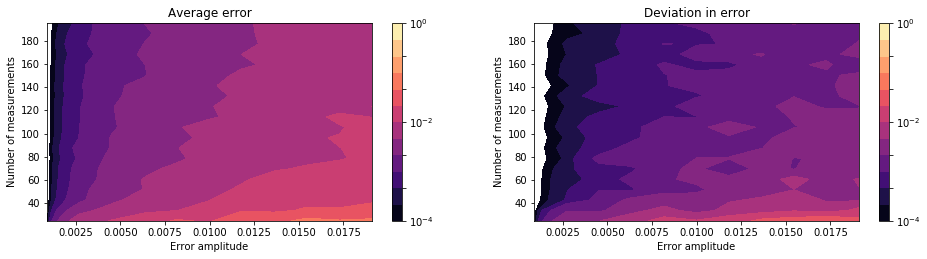

<Figure size 432x288 with 0 Axes>

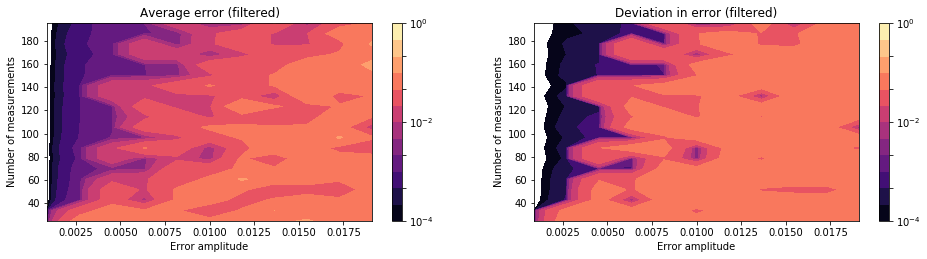

<Figure size 432x288 with 0 Axes>

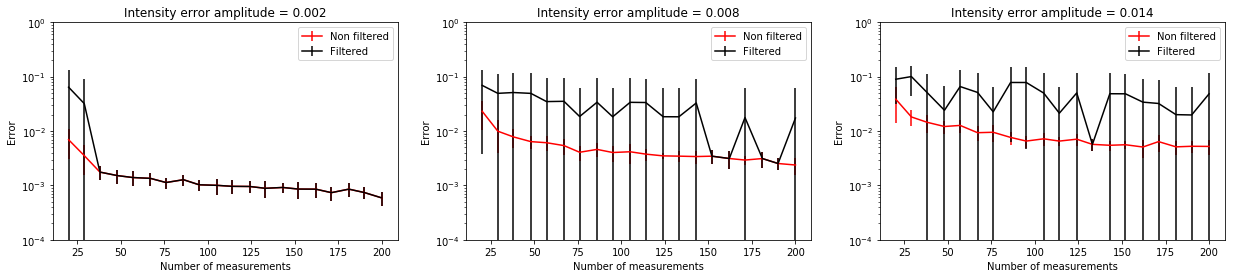

In [86]:
Nlevels = 3

# Plot 2D
#print([narray.shape, aarray.shape, error.shape])
extension = sp.array([aarray[0], aarray[-1], narray[0], narray[-1]])
Zinfo = [mean_error, dev_error, mean_error_filtered, dev_error_filtered]
plot_4_contours(Zinfo, extension, aspect_ratio, LowThres, HighThres, Nlevels=Nlevels)

# Plot 1D
Zinfo = [mean_error[:,indicesA[0]], mean_error_filtered[:,indicesA[0]], 
        mean_error[:,indicesA[1]], mean_error_filtered[:,indicesA[1]], 
        mean_error[:,indicesA[2]], mean_error_filtered[:,indicesA[2]]]
DZinfo = [dev_error[:,indicesA[0]], dev_error_filtered[:,indicesA[0]], 
         dev_error[:,indicesA[1]], dev_error_filtered[:,indicesA[1]],
         dev_error[:,indicesA[2]], dev_error_filtered[:,indicesA[2]]]
titles = ['Intensity error amplitude = {}'.format(aarray[indicesA[0]]), 
         'Intensity error amplitude = {}'.format(aarray[indicesA[1]]), 
         'Intensity error amplitude = {}'.format(aarray[indicesA[2]]) ]
legends = ['Non filtered', 'Filtered']
xlabel = 'Number of measurements'
plot_3_cortes(narray, Zinfo,DZinfo, xlabel, titles, legends, LowThres, HighThres, logscale=True)

** Retardador diatenuante**

In [87]:
# Parameters
(n0, n1, nn) = (20, 200, 20) # Number of intensity measurements: min, max and Nvalues
#(a0, a1, an) = (0, 0.05, 11) # Amplitude of errors: min, max and Nvalues
(a0, a1, an) = (0, 0.02, 11) # Amplitude of errors: min, max and Nvalues
Naverage = 10 # Number of times the experiment is repeated in order to average errors
angle_limits = [0, pi, pi, 0] # Limits in the movement of motors
Nmax_angles = [0, 0, 0, 0] # Maximum number of different partitions in each motor (0 is no limit)
method_angles = 'linear'
threshold = 0.5
thresholdDev = 0.5
tolerance_filter = 0.01
aspect_ratio = 0.8e-4
LowThres = 1e-4
HighThres = 1
FilterThres = 1
indicesA = [1, 4, 7]

# Create target matrix
Mtarget = ps.Mueller_Real_Retarder(0.95, 0.8, 90*degrees)
Mtarget = ps.rotate_mueller(Mtarget, 30*degrees)
Mpolarimeter = [Jp1, Jr1, Mtarget, Jr2, Jp2]

# Create  and initialize variables
narray = np.linspace(n0, n1, nn, dtype = 'int')
aarray = np.linspace(a0, a1, an)
mean_error = np.zeros((nn, an))
dev_error = np.zeros((nn, an))
mean_error_filtered = np.zeros((nn, an))
dev_error_filtered = np.zeros((nn, an))

# Loops introducing error
for indN, n_meas in enumerate(narray):
    for indA, a_error in enumerate(aarray): 
        # Initialize values
        error = np.zeros(Naverage)
        error_filtered = np.zeros(Naverage)
        for indAver in range(Naverage):
            # Angles
            angles = generate_even_distribution(n_meas, angle_limits, method_angles, Nmax_angles)
            # Simulated polarimeter experiment
            Iexp = np.zeros(n_meas)
            for indExp in range(n_meas):
                # Calculate the exact value
                th2 = [angles[0,indExp], angles[1,indExp], 0, angles[2,indExp], angles[3,indExp]]
                Iexp[indExp] = Intensity_Rotating_Elements(Mpolarimeter, th2, Ifuente)
                # Add noise
                noise = np.sign(np.random.rand(1)-0.5) * a_error * sqrt(np.log(np.random.rand(1)**(-1)))
                #print(noise)
                Iexp[indExp] = (1 + noise) * Iexp[indExp]
            # Calculate the matrix of the sample
            Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Iexp, angles)
            #print(Mcalculated)
            # Calculate error
            error[indAver] = np.std(Mtarget-Mcalculated)
            # Filter it if the error is not too high (in those cases we obtain errors)
            #print(error[indAver])
            if error[indAver] > FilterThres:
                Mfiltered = np.identity(4)*10
            else:
                Mfiltered = amm.filter_reality_conditions(Mcalculated, tolerance_filter, verbose=False)
            error_filtered[indAver] = np.std(Mtarget-Mfiltered)
        # Average error
        mean_error[indN, indA] = np.mean(error)
        dev_error[indN, indA] = np.std(error)
        mean_error_filtered[indN, indA] = np.mean(error_filtered)
        dev_error_filtered[indN, indA] = np.std(error_filtered)
        


<Figure size 432x288 with 0 Axes>

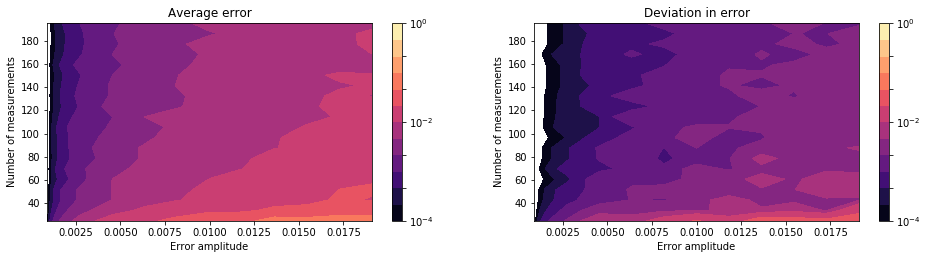

<Figure size 432x288 with 0 Axes>

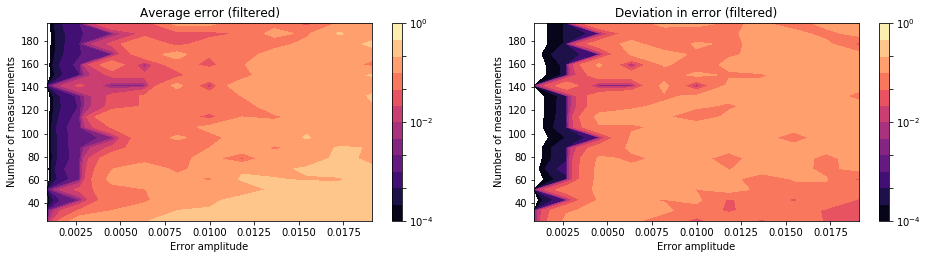

<Figure size 432x288 with 0 Axes>

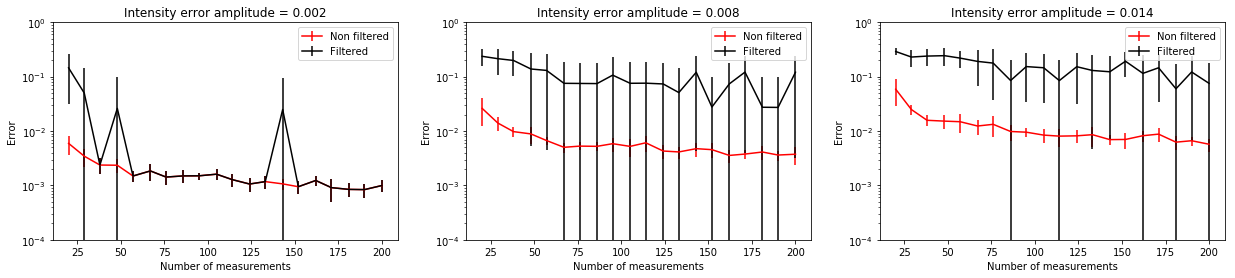

In [88]:
Nlevels = 3

# Plot 2D
#print([narray.shape, aarray.shape, error.shape])
extension = sp.array([aarray[0], aarray[-1], narray[0], narray[-1]])
Zinfo = [mean_error, dev_error, mean_error_filtered, dev_error_filtered]
plot_4_contours(Zinfo, extension, aspect_ratio, LowThres, HighThres, Nlevels=Nlevels)

# Plot 1D
Zinfo = [mean_error[:,indicesA[0]], mean_error_filtered[:,indicesA[0]], 
        mean_error[:,indicesA[1]], mean_error_filtered[:,indicesA[1]], 
        mean_error[:,indicesA[2]], mean_error_filtered[:,indicesA[2]]]
DZinfo = [dev_error[:,indicesA[0]], dev_error_filtered[:,indicesA[0]], 
         dev_error[:,indicesA[1]], dev_error_filtered[:,indicesA[1]],
         dev_error[:,indicesA[2]], dev_error_filtered[:,indicesA[2]]]
titles = ['Intensity error amplitude = {}'.format(aarray[indicesA[0]]), 
         'Intensity error amplitude = {}'.format(aarray[indicesA[1]]), 
         'Intensity error amplitude = {}'.format(aarray[indicesA[2]]) ]
legends = ['Non filtered', 'Filtered']
xlabel = 'Number of measurements'
plot_3_cortes(narray, Zinfo,DZinfo, xlabel, titles, legends, LowThres, HighThres, logscale=True)